In [1]:
from numpy import asarray
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score
from statistics import mean
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import pickle

In [2]:
# Import data and clean
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# load the dataset
series = read_csv('cases2.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=5)
# print(train)

[1. 1. 1. 1. 1.]  :  1.268339841647424  :  1.0
[1. 1. 1. 1. 1.]  :  1.268339841647424  :  4.0
[31. 31. 36. 38. 35.]  :  38.643  :  28.0
[1. 1. 4. 1. 4.]  :  1.497  :  3.0
[1. 2. 2. 1. 1.]  :  1.6236969696969696  :  2.0
[3. 6. 8. 4. 3.]  :  5.73  :  7.0
[3. 9. 5. 1. 5.]  :  3.801  :  8.0
[125. 159. 131. 109.  90.]  :  89.557  :  61.0
[1. 1. 1. 1. 1.]  :  1.268339841647424  :  1.0
[36. 84. 52. 33. 42.]  :  55.699  :  56.0
[5. 1. 5. 8. 5.]  :  4.49725  :  3.0
[4. 1. 1. 1. 1.]  :  1.1013583416712287  :  1.0
[2. 1. 1. 1. 1.]  :  1.0183709589856011  :  1.0
[1. 2. 1. 1. 1.]  :  3.1458242308336657  :  1.0
[391. 250. 322. 158. 230.]  :  166.324  :  125.0
[1. 1. 1. 1. 1.]  :  1.268339841647424  :  1.0
[1. 5. 2. 8. 4.]  :  4.596104761904762  :  3.0
[2. 1. 1. 2. 2.]  :  1.2964119047619045  :  1.0
[2. 3. 7. 4. 6.]  :  4.748633333333333  :  10.0
[2. 1. 1. 2. 3.]  :  1.3389119047619047  :  7.0
[35. 41. 31. 31. 36.]  :  36.511  :  38.0
[1. 2. 1. 1. 1.]  :  3.1458242308336657  :  2.0
[1. 5. 8. 5. 3.]  

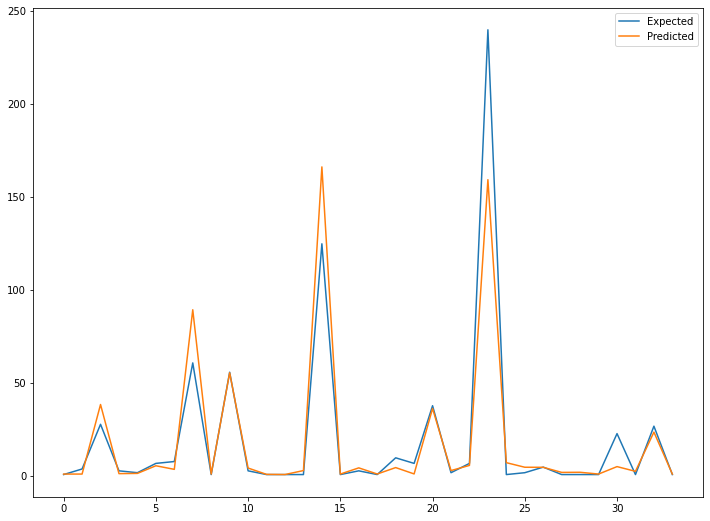

In [11]:
# split into input and output columns
X, y = train[:, :-1], train[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, y_train)
filename = 'location_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# get test stats
predictions = model.predict(X_test)
# print(classification_report(y_test,predictions))
id = 0
error = []
for i in X_test:
    print(i, " : ", predictions[id], " : ", y_test[id])
    error.append(y_test[id] - predictions[id])
    id +=1

print("Average Error:",mean(error))

# construct an input for a new prediction
low = -6
up = low + 5
row = values[low:up].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input:',row,' Predicted:',yhat[0], "Actual:", int(values[up]))

fig = plt.figure(figsize=(12,9))
plt.plot(y_test, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [4]:
# Create the data
import csv
postcode = 2500

df = pd.read_csv('australian_postcodes.csv')
dataLat = {}
dataLon = {}
for index, row in df.iterrows():
    if row['state'] == 'NSW':
        dataLat[row['postcode']] = row['lat']
        dataLon[row['postcode']] = row['long']
df2 = pd.read_csv('cases_locations.csv')
df2['sum'] = 1
df2 = df2.groupby(['notification_date', 'postcode']).agg({'sum':'sum'}).reset_index()
df2 = df2[df2.astype(str).ne('None').all(1)]
df2['postcode'] = df2['postcode'].astype(float).astype(int)
df2['lat'] = df2['postcode'].map(dataLat)
df2['lon'] = df2['postcode'].map(dataLon)
df2 = df2.dropna()

writer = csv.writer(open("casesTemp.csv", "w", newline=""), delimiter=",")
header = ['date', 'cases']
writer.writerow(header)
# Create graph of cases at the UOW postcode
dates = []
cases = []
for id, i in df2.iterrows():
    if i['postcode'] == postcode:
        # print(i['notification_date'], "number", i['sum'])
        dates.append(i['notification_date'])
        cases.append(i['sum'])
        writer.writerow([i['notification_date'],i['sum']])


# load the dataset
series = read_csv('casesTemp.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=5)

X, y = train[:, :-1], train[:, -1]

# print(train)
# print(y)

predictions = model.predict(X)
# print(classification_report(y_test,predictions))

id = 0
error = []
for i in X:
    print(i, " : ", predictions[id], " : ", y[id])
    error.append(y[id] - predictions[id])
    id +=1

print("Average Error:",mean(error))

# construct an input for a new prediction
for i in range(-10,-5):
    # low = -6
    low = i
    up = low + 5
    row = values[low:up].flatten()
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    print('Input:',row,' Predicted:',yhat[0], "Actual:", int(values[up]))

fig = plt.figure(figsize=(12,9))
plt.plot(y, label='Daily Cases')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

EmptyDataError: No columns to parse from file

In [ ]:
import json
writer = csv.writer(open("slidingWindow.csv", "w", newline=""), delimiter=",")
# Send data into file:
json.dump( UOW_popularTimes, open( "slidingWindow.json", 'w' ) )
